#  Random Forest Classifier (Electrofacies).

* **Autor:** Rodrigo Lopez Aburto
* **Versión:** 1.0
* **Fecha:** Junio 2023

### Summary.

This notebook follows the steps needed to train and use a random forest classifier to estimate electrofacies in an area where only 25 per cent of the samples have an electrofacies label. With this objective in mind, the notebook describes the process of data input, exploratory data analysis, data preparation, training, testing, and result analysis. Four different algorithms of the same kind (Random Forest) are used and compared prior to selecting the one in which results will be evaluated.

**Carga de las bibliotecas**

In [1]:
## Standard Libraries.
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import mode

## Data visualization libraries.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Data science libraries.
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

## Random forest libraries.
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

## Metric libraries.
from sklearn import metrics
from sklearn.model_selection import cross_val_score

**External Functions**

In [2]:
from Funciones.GraphStatEng import *

**Data Import**

The well logs from 19 wells were loaded. This file had been previously modified during the clustering process, where labels for 25 per cent of the total samples were assigned. Therefore, this notebook used the same four well logs used for the cluster analysis (ECGR, DTCO, NPHI, and RHOZ) as well as the labels obtained from the cluster analysis. Some other columns were loaded since they were necessary to sort and identify information.
For this notebook, the classification used comes from the Self-Organising maps method.

In [3]:
registros_cargados = ['Well_ID','DEPT','ECGR','RHOZ','DTCO','NPHI','PoroFluido','Arcilla','Sw','SOM_4_Classes']
registros = ['ECGR','RHOZ','DTCO','NPHI']

In [4]:
currdir = os.getcwd()
df_CHTC = pd.read_csv(currdir + '\\Datos\\Electrofacies_SOM.csv', 
                            usecols=registros_cargados, low_memory=False, na_values=-999.25)

In [5]:
print('%i samples were loaded' %df_CHTC.shape[0])

75238 samples were loaded


For practicality, a second DataFrame was created containing only the samples with an assigned label. At the same time, the dimensions of the data are verified by counting the null values in the original DataFrame.


In [71]:
df_CHTC_labeled = df_CHTC.copy()
df_CHTC_labeled.dropna(axis=0,inplace=True)
print('%i samples had an assigned electrofacies' %df_CHTC_labeled.shape[0])

18810 samples had an assigned electrofacies


### Data Standardisation.

The goal is to use the well logs as input for a classifier. To achieve this, it is necessary to remove their dependency on measurement units; this is done to avoid the impact different ranges might have on the classifier's performance. Standardisation was conducted by subtracting the mean and dividing by the variance to obtain a distribution with zero mean and variance close to one.

Two options are presented; the first one conducts standardisation well-to-well before integrating all wells back into a single data frame, while the second option uses the whole data frame as input and conducts the standardisation. 

**Standarization by well**

In [7]:
Pozos = list(df_CHTC['Well_ID'].value_counts(sort=False).index)

In [8]:
resultado = []
scaler = StandardScaler()
for pozo in Pozos:
    standarized_data = scaler.fit_transform(df_CHTC[df_CHTC['Well_ID'] == pozo][registros])
    resultado = resultado + standarized_data.tolist()
df_standard = pd.DataFrame(resultado, columns=registros, index=df_CHTC.index)
Estadigrafos(df_standard,['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,75238.00,75238.00,75238.00,75238.00
Minimum,-5.37,-10.49,-4.28,-4.46
1st quartile,-0.61,-0.64,-0.78,-0.68
Median,0.22,0.02,0.19,0.22
Mean,-0.00,-0.00,0.00,-0.00
3rd quartile,0.71,0.65,0.74,0.71
Maximum,6.41,5.33,3.27,5.53
Range,11.78,15.82,7.55,9.99
IQR,1.32,1.29,1.53,1.39
Variance,1.00,1.00,1.00,1.00


**Global standarization**

In [9]:
#scaler = StandardScaler()
#df_original_Standard = scaler.fit_transform(df_original[registros]) 
#df_standard = pd.DataFrame(df_original_Standard, columns=registros)
#for registro in registros:
#    fig, axs = Plot_Hist(df_standard[registro], 12, 'dec', 12);
#    fig.savefig(currdir + '\Resultados\\Histograma_%s_std.png' % registro,
#                format="png", bbox_inches="tight", facecolor='white', dpi=300);

In [10]:
df_CHTC_standard = pd.concat([df_CHTC['DEPT'],df_CHTC['Well_ID'],df_standard,df_CHTC_labeled['SOM_4_Classes']], axis=1)
df_CHTC_standard.shape

(75238, 7)

### Multivariate Analysis.

Under normal circumstances, exploratory data analysis would be recommended, but in this particular case, the result analysis of the clustering process can be thought of as an exploratory analysis for this stage; statistics and graphs have already been analysed. Considering the classifier targets a categorical variable, the data analysis conducted in this section, rather than focusing on exploring the data, is focusing on exploring the relationship between the target variable and the variables that will be used to predict it. This section covers techniques such as principal component analysis and feature selection to optimise the input for the following process.

### Principal Component Analysis (PCA) Application.

In [11]:
pcamodel = PCA(n_components=3, random_state=0)
pca = pcamodel.fit_transform(df_CHTC_standard[registros])
Tabla_PCA(pcamodel)

,Principal_Component,Explained Variance,Explained Variance Ratio
0,PC 1,3.241497,0.810363
1,PC 2,0.525363,0.131339
2,PC 3,0.144944,0.036236


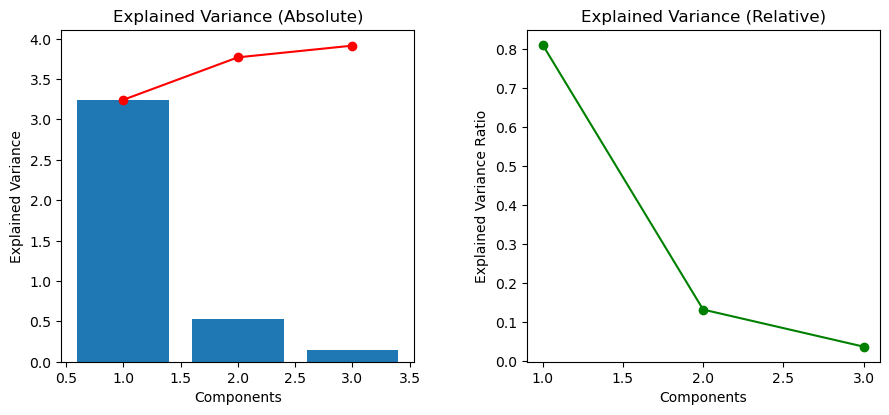

In [12]:
Graficar_varianza_PCA(pcamodel); plt.show()

De manera similar al caso de los registros normalizados se creo un DataFrame para almacenar las componentes principales y las clases en un solo lugar.

In [13]:
df_temp = pd.DataFrame(data=pca, columns=['PC' + str(i) for i in range(1,3 + 1)], index=df_CHTC_standard.index)
df_pca = pd.concat([df_CHTC['DEPT'],df_CHTC['Well_ID'],df_temp,df_CHTC['SOM_4_Classes']], axis=1)
df_pca_labeled = df_pca.copy(); df_pca_labeled.dropna(inplace=True)
df_pca.head(5)

,DEPT,Well_ID,PC1,PC2,PC3,SOM_4_Classes
0,1126.0836,A3,4.087948,0.617946,0.215129,NaN
1,1126.2360,A3,3.743428,0.708824,0.183287,3.0
2,1126.3884,A3,3.315016,0.969296,-0.658424,NaN
3,1126.5408,A3,2.333968,1.108673,-0.958215,NaN
4,1126.6932,A3,1.991692,1.209390,-1.180054,NaN


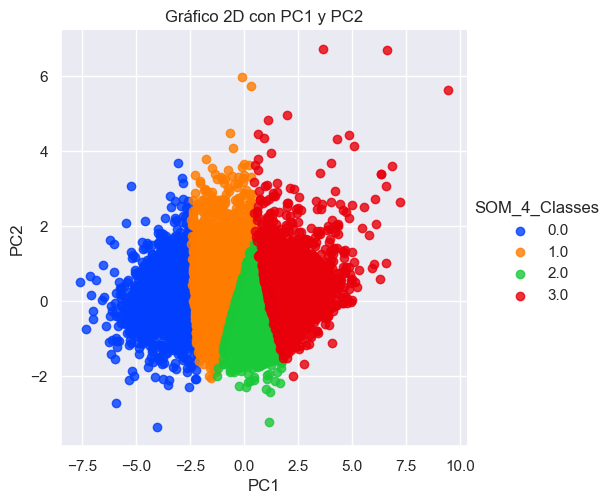

In [14]:
sns.set()
sns.lmplot(x='PC1', y='PC2', data=df_pca_labeled,
           fit_reg=False, legend=True, hue='SOM_4_Classes', palette='bright')
plt.title('Gráfico 2D con PC1 y PC2'); plt.show()

### Feature Selection.

Another helpful tool for understanding how variables relate to the target variable is quantifying each one's relevance to the current classification; this is done by estimating the F-score value and the mutual information index. Both of these methods provide insight into which variables are more meaningful to the current classification.

**ANOVA/F-Test**

In [15]:
f_statistic_completo, p_values = f_classif(df_CHTC_labeled[registros],
                                           df_CHTC_labeled['SOM_4_Classes'])
d = {'label': df_CHTC_labeled[registros].columns, 'f_statistic': f_statistic_completo}
f_df = pd.DataFrame(data=d)
f_sorted = f_df.sort_values(by=['f_statistic'], ascending=False)
f_sorted;

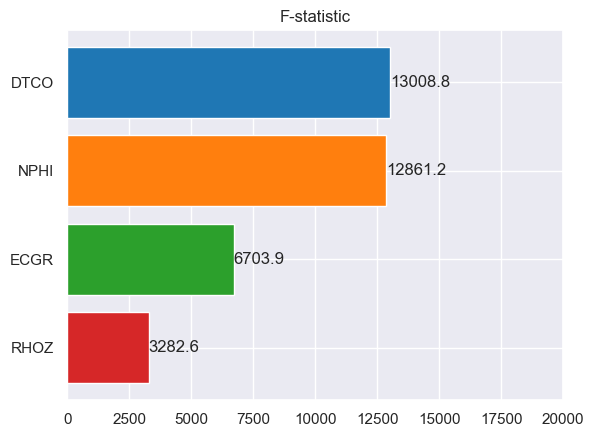

In [16]:
fig, ax = plt.subplots()
#class_plot = ax.barh(df_recortado[registros].columns, f_statistic, color=mcolors.TABLEAU_COLORS)
class_plot = ax.barh(f_sorted['label'], f_sorted['f_statistic'], color=mcolors.TABLEAU_COLORS)

ax.set_title('F-statistic')
ax.bar_label(class_plot, fmt='%.1f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=20000)
plt.show()
#fig.savefig('F-Static.png')

**Mutual Information**

In [17]:
mi = mutual_info_classif(df_CHTC_labeled[registros], df_CHTC_labeled['SOM_4_Classes'])
d = {'label': df_CHTC_labeled[registros].columns, 'mi': mi}
mi_df = pd.DataFrame(data=d)
mi_sorted = mi_df.sort_values(by=['mi'], ascending=False)
mi_sorted;

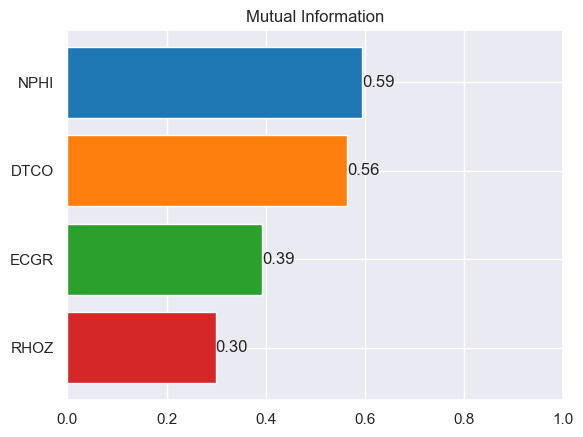

In [18]:
fig, ax = plt.subplots()
class_plot = ax.barh(mi_sorted['label'], mi_sorted['mi'], color=mcolors.TABLEAU_COLORS)
ax.set_title('Mutual Information')
ax.bar_label(class_plot, fmt='%.2f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=1)
plt.show()
#fig.savefig('Mutual_Information.png')

### Dendrograma.

Buscando comprender mejor la forma en la que las clases se van construyendo, se graficó un dendrograma con el objetivo de analizar la manera en la que agrupan los datos. Para esto se utilizó una funcionalidad de la biblioteca de Scipy llamada "dendrogram". La ejecución de esta función requiere dos pasos. Un primer paso donde se estiman las distancias entre los diferentes puntos de los datos con respecto a los clústeres hipotéticos. Esto se realizó tomando la distancia euclidiana y el método se seleccionó como "Warp".

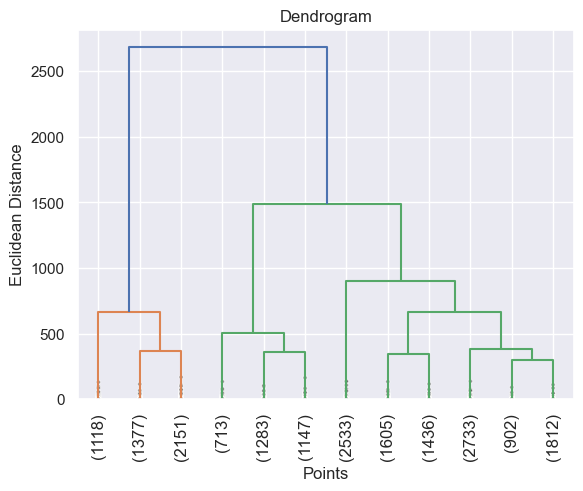

In [19]:
Dendro = linkage(df_CHTC_labeled[registros], metric='euclidean', method='ward')
plt.title('Dendrogram'); plt.xlabel('Points'); plt.ylabel('Euclidean Distance')
dendrogram(Dendro, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.show()
#plt.savefig('Dendrogram.png')

### Visualización de las clases.

Considerando que durante el análisis exploratorio de datos se observó un cierto desbalance en las clases, se procedió a confirmar esto, buscando que la separación del set de datos respetase estas proporciones. Para este propósito primero se grafica un conteo de las clases de los datos originales y posteriormente se grafica el conteo correspondiente a las clases en los sets de datos de entrenamiento y prueba.

In [20]:
df_Categories_original = pd.DataFrame(data=df_CHTC_labeled['SOM_4_Classes'].value_counts().sort_index(ascending=True))
df_Categories_original.reset_index(inplace=True); df_Categories_original.columns = ['SOM_4_Classes', 'COUNT']
df_Categories_original

,SOM_4_Classes,COUNT
0,0.0,2282
1,1.0,4607
2,2.0,6769
3,3.0,5152


### Creación del set de entrenamiento.

Unsupervised learning methods need to undergo a training and testing stage before they can be exposed to new data; to this end, it is necessary to split the labelled dataset into a subset for training and a subset for testing the classifier's performance. For this work, the training dataset contains 70 per cent of the labelled samples, while the training dataset contains the remaining 30 per cent.

Likewise, considering there are two different datasets, one made of the principal components and one made of the standardised well logs, the splitting was performed twice, once on each dataset.

**Para los registros estandarizados**

In [21]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(
    df_CHTC_labeled[registros], df_CHTC_labeled['SOM_4_Classes'], train_size=0.7, random_state=5)

**Para las componentes principales**

In [22]:
X_Train_pca, X_Test_pca, Y_Train_pca, Y_Test_pca = train_test_split(
    df_pca_labeled[['PC1','PC2','PC3']],
    df_pca_labeled['SOM_4_Classes'], train_size=0.7, random_state=0)

**Class count**

 Once the dataset had been split, the classes were counted to ensure the representativity between datasets.

In [23]:
df_Categories_Train = Contar_Clases(Y_Train, 'SOM_4_Classes')
df_Categories_Train

,SOM_4_Classes,COUNT,PERCENT
0,0.0,1563,11.870586
1,1.0,3233,24.553809
2,2.0,4790,36.378826
3,3.0,3581,27.196780


In [24]:
df_Categories_Test = Contar_Clases(Y_Test, 'SOM_4_Classes')
df_Categories_Test

,SOM_4_Classes,COUNT,PERCENT
0,0.0,719,12.741450
1,1.0,1374,24.348751
2,2.0,1979,35.069998
3,3.0,1571,27.839802


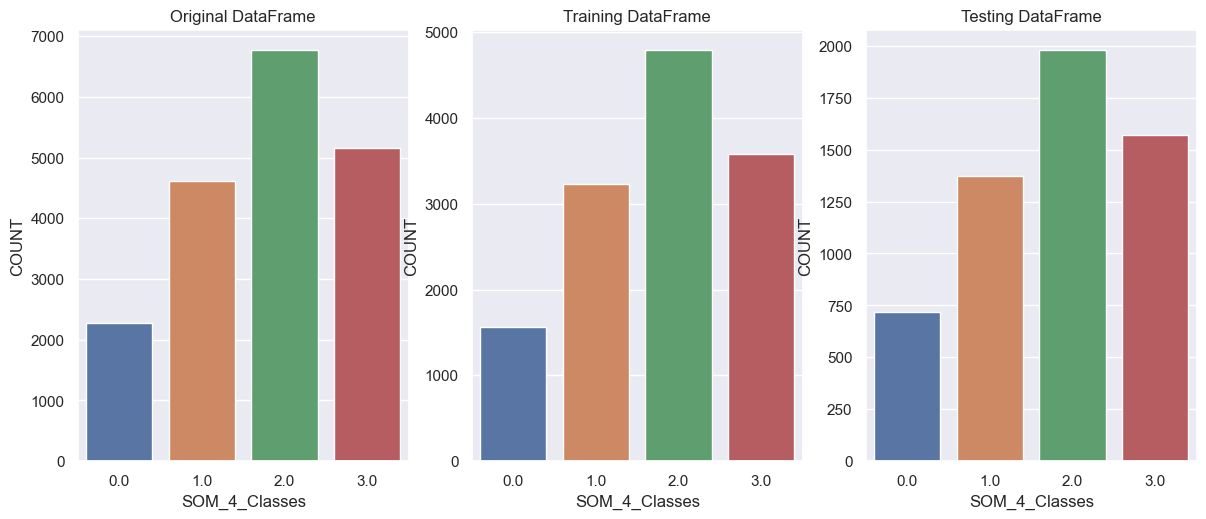

In [25]:
Graficar_Set(df_Categories_original,df_Categories_Train,df_Categories_Test,'SOM_4_Classes'); plt.show()
#plt.savefig('Class_Count.png')

## Random Forest Classifier training and testing.

The next step is to train the classifiers. In this section, four different classifiers from the same group (Random Forest) were trained, each with a weight system to diminish the impact of imbalanced classes in the prediction. Metrics and confusion matrixes are provided, and at the end of the section, a summary of the results is presented, intended to aid in the selection of the best model. 

In [26]:
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=800, max_depth=6, bootstrap=True, 
                                  class_weight='balanced_subsample', criterion='gini', random_state=0)    
rf_model.fit(X_Train, Y_Train)
print('RF score de entrenamiento: ', rf_model.score(X_Train, Y_Train))
finish_time = time.time(); tiempo_entrenamiento_rf = finish_time - start_time
print('Training time ', tiempo_entrenamiento_rf, 'segundos') 

RF score de entrenamiento:  0.7900812637654743
El tiempo que tarda entrenar es de  10.55679178237915 segundos


### Training metrics.

In [27]:
predicted_rf = pd.DataFrame(rf_model.predict(X_Train), columns=['Y_Predicted'])
probs_rf = pd.DataFrame(rf_model.predict_proba(X_Train))

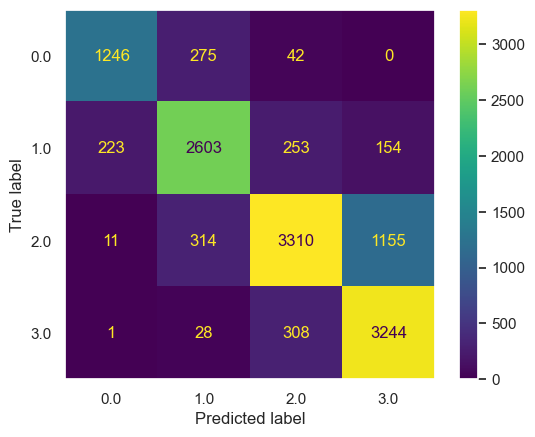

In [28]:
rf_ConfusionMatrix = metrics.confusion_matrix(Y_Train, predicted_rf.to_numpy())
disp = metrics.ConfusionMatrixDisplay(rf_ConfusionMatrix, display_labels=rf_model.classes_)
disp.plot(); plt.grid(visible=False); 

In [29]:
rf_accuracy = metrics.accuracy_score(Y_Train, predicted_rf)
rf_roc_auc = metrics.roc_auc_score(Y_Train, probs_rf.to_numpy(), multi_class='ovo')
rf_confus_matrix = metrics.confusion_matrix(Y_Train, predicted_rf)
rf_classification_report = metrics.classification_report(Y_Train, predicted_rf, zero_division=1)
rf_precision = metrics.precision_score(Y_Train, predicted_rf, pos_label=1, average='macro', zero_division=0)
rf_recall = metrics.recall_score(Y_Train, predicted_rf, pos_label=1, average='macro', zero_division=0)
rf_f1 = metrics.f1_score(Y_Train, predicted_rf, pos_label=1, average='macro', zero_division=0)

### Metricas en el set de validacion.

In [30]:
predicted_rf1 = pd.DataFrame(rf_model.predict(X_Test), columns=['Y_Predicted'])
probs_rf1 = pd.DataFrame(rf_model.predict_proba(X_Test))

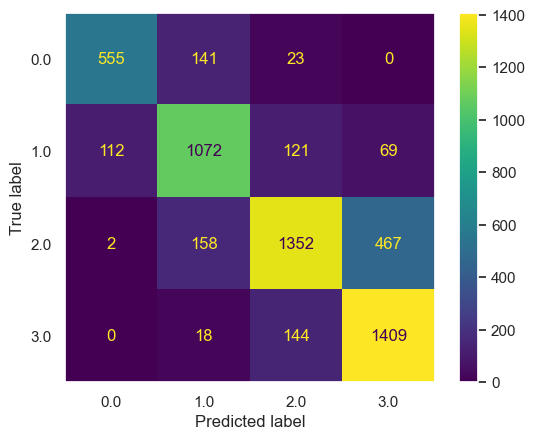

In [31]:
rf_ConfusionMatrix1 = metrics.confusion_matrix(Y_Test, predicted_rf1.to_numpy())
disp1 = metrics.ConfusionMatrixDisplay(rf_ConfusionMatrix1, display_labels=rf_model.classes_)
disp1.plot(); plt.grid(visible=False); 

In [32]:
rf_accuracy1 = metrics.accuracy_score(Y_Test, predicted_rf1)
rf_roc_auc1 = metrics.roc_auc_score(Y_Test, probs_rf1.to_numpy(), multi_class='ovo')
rf_precision1 = metrics.precision_score(Y_Test, predicted_rf1, pos_label=1, average='macro', zero_division=0)
rf_recall1 = metrics.recall_score(Y_Test, predicted_rf1, pos_label=1, average='macro', zero_division=0)
rf_f11 = metrics.f1_score(Y_Test, predicted_rf1, pos_label=1, average='macro', zero_division=0)

In [33]:
models = pd.DataFrame({'Model':['Random Forest Train', 'Random Forest Test'],'Accuracy'
                       :[rf_accuracy,rf_accuracy1],'Precision':[rf_precision,rf_precision1],
                       'recall':[rf_recall,rf_recall1],'F1':[rf_f1,rf_f11],'AUC ROC':[rf_roc_auc,rf_roc_auc1]})
models.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,recall,F1,AUC ROC
0,Random Forest Train,0.790081,0.802026,0.799809,0.795928,0.959200
1,Random Forest Test,0.777601,0.787547,0.783041,0.781082,0.950769


## Random Forest Extra Classifier.

In [34]:
start_time = time.time()
rf_model_extra = ExtraTreesClassifier(n_estimators=1000, max_depth=7, bootstrap=True, 
                                  class_weight='balanced_subsample', criterion='gini', random_state=0)    
rf_model_extra.fit(X_Train, Y_Train)
print('RF score de entrenamiento: ', rf_model_extra.score(X_Train, Y_Train))
finish_time = time.time(); tiempo_entrenamiento_rfExtra = finish_time - start_time
print('Training time', tiempo_entrenamiento_rfExtra, 'segundos') 

RF score de entrenamiento:  0.7654742917900813
El tiempo que tarda entrenar es de  5.69579291343689 segundos


### Metricas en el set de entrenamiento.

In [35]:
predicted_rf_extra = pd.DataFrame(rf_model_extra.predict(X_Train), columns=['Y_Predicted'])
probs_rf_extra = pd.DataFrame(rf_model_extra.predict_proba(X_Train))

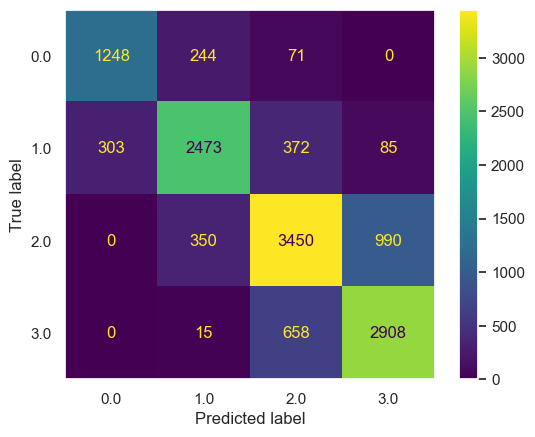

In [36]:
rf_ConfusionMatrix = metrics.confusion_matrix(Y_Train, predicted_rf_extra.to_numpy())
disp = metrics.ConfusionMatrixDisplay(rf_ConfusionMatrix, display_labels=rf_model_extra.classes_)
disp.plot(); plt.grid(visible=False); 

In [37]:
rf_extra_accuracy = metrics.accuracy_score(Y_Train, predicted_rf_extra)
rf_extra_roc_auc = metrics.roc_auc_score(Y_Train, probs_rf_extra.to_numpy(), multi_class='ovo')
rf_extra_confus_matrix = metrics.confusion_matrix(Y_Train, predicted_rf_extra)
rf_extra_classification_report = metrics.classification_report(Y_Train, predicted_rf_extra, zero_division=1)
rf_extra_precision = metrics.precision_score(Y_Train, predicted_rf_extra, pos_label=1, average='macro', zero_division=0)
rf_extra_recall = metrics.recall_score(Y_Train, predicted_rf_extra, pos_label=1, average='macro', zero_division=0)
rf_extra_f1 = metrics.f1_score(Y_Train, predicted_rf_extra, pos_label=1, average='macro', zero_division=0)

### Metricas en el set de Validacion.

In [38]:
predicted_rf_extra1 = pd.DataFrame(rf_model_extra.predict(X_Test), columns=['Y_Predicted'])
probs_rf_extra1 = pd.DataFrame(rf_model_extra.predict_proba(X_Test))

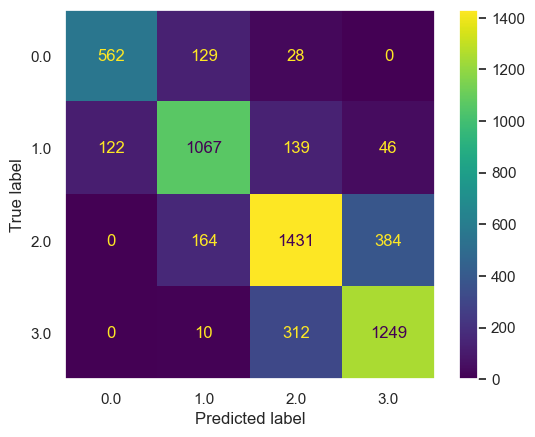

In [39]:
rf_ConfusionMatrix1 = metrics.confusion_matrix(Y_Test, predicted_rf_extra1.to_numpy())
disp1 = metrics.ConfusionMatrixDisplay(rf_ConfusionMatrix1, display_labels=rf_model_extra.classes_)
disp1.plot(); plt.grid(visible=False); 

In [40]:
rf_extra_accuracy1 = metrics.accuracy_score(Y_Test, predicted_rf_extra1)
rf_extra_roc_auc1 = metrics.roc_auc_score(Y_Test, probs_rf_extra1.to_numpy(), multi_class='ovo')
rf_extra_precision1 = metrics.precision_score(Y_Test, predicted_rf_extra1, pos_label=1, average='macro', zero_division=0)
rf_extra_recall1 = metrics.recall_score(Y_Test, predicted_rf_extra1, pos_label=1, average='macro', zero_division=0)
rf_extra_f11 = metrics.f1_score(Y_Test, predicted_rf_extra1, pos_label=1, average='macro', zero_division=0)

In [41]:
models_extra = pd.DataFrame({'Model':['Random Forest (Extra) Train', 'Random Forest (Extra) Test'],'Accuracy'
                       :[rf_extra_accuracy,rf_extra_accuracy1],'Precision':[rf_extra_precision,rf_extra_precision1],
                       'recall':[rf_extra_recall,rf_extra_recall1],'F1':[rf_extra_f1,rf_extra_f11],'AUC ROC':[rf_extra_roc_auc,rf_extra_roc_auc1]})
models_extra.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,recall,F1,AUC ROC
0,Random Forest (Extra) Train,0.765474,0.773805,0.773926,0.773085,0.944602
1,Random Forest (Extra) Test,0.763601,0.773395,0.769083,0.770844,0.940894


## Random Forest Classifier with PCA.

In [42]:
start_time = time.time()
rf_model_pca = RandomForestClassifier(n_estimators=100, max_depth=5, bootstrap=False, class_weight='balanced', random_state=0)    
rf_model_pca.fit(X_Train_pca, Y_Train_pca)
print('RF score de entrenamiento: ', rf_model_pca.score(X_Train_pca, Y_Train_pca))
finish_time = time.time(); tiempo_entrenamiento_rfPCA = finish_time - start_time
print('Training time', tiempo_entrenamiento_rfPCA, 'segundos')

RF score de entrenamiento:  0.9638490164805954
El tiempo que tarda entrenar es de  0.9664511680603027 segundos


### Metricas en el set de entrenamiento.

In [43]:
predicted_rf_pca = pd.DataFrame(rf_model_pca.predict(X_Train_pca), columns=['Y_Predicted'])
probs_rf_pca = pd.DataFrame(rf_model_pca.predict_proba(X_Train_pca))

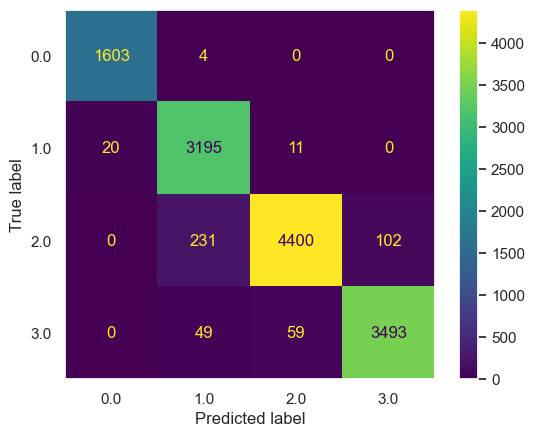

In [44]:
rf_pca_ConfusionMatrix = metrics.confusion_matrix(Y_Train_pca, predicted_rf_pca.to_numpy())
disp = metrics.ConfusionMatrixDisplay(rf_pca_ConfusionMatrix, display_labels=rf_model_pca.classes_)
disp.plot(); plt.grid(visible=False); plt.show()

In [45]:
rf_pca_accuracy = metrics.accuracy_score(Y_Train_pca, predicted_rf_pca)
rf_pca_roc_auc = metrics.roc_auc_score(Y_Train_pca, probs_rf_pca.to_numpy(), multi_class='ovo')
rf_pca_confus_matrix = metrics.confusion_matrix(Y_Train_pca, predicted_rf_pca)
rf_pca_classification_report = metrics.classification_report(Y_Train_pca, predicted_rf_pca, zero_division=1)
rf_pca_precision = metrics.precision_score(Y_Train_pca, predicted_rf_pca, pos_label=1, average='macro', zero_division=0)
rf_pca_recall = metrics.recall_score(Y_Train_pca, predicted_rf_pca, pos_label=1, average='macro', zero_division=0)
rf_pca_f1 = metrics.f1_score(Y_Train_pca, predicted_rf_pca, pos_label=1, average='macro', zero_division=0)

### Metricas en el set de validacion.

In [46]:
predicted_rf1_pca = pd.DataFrame(rf_model_pca.predict(X_Test_pca), columns=['Y_Predicted'])
probs_rf1_pca = pd.DataFrame(rf_model_pca.predict_proba(X_Test_pca))

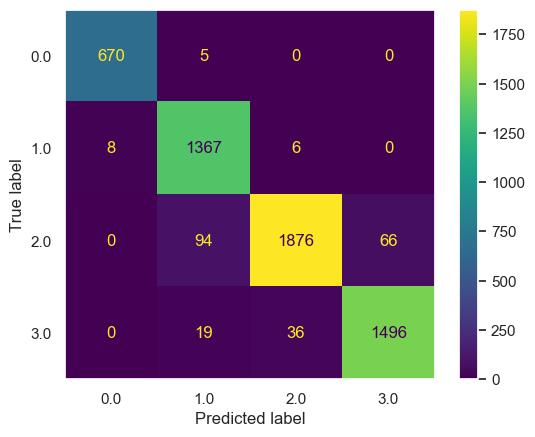

In [47]:
rf_pca_ConfusionMatrix1 = metrics.confusion_matrix(Y_Test_pca, predicted_rf1_pca.to_numpy())
disp1 = metrics.ConfusionMatrixDisplay(rf_pca_ConfusionMatrix1, display_labels=rf_model_pca.classes_)
disp1.plot(); plt.grid(visible=False); plt.show()

In [48]:
rf_pca_accuracy1 = metrics.accuracy_score(Y_Test_pca, predicted_rf1_pca)
rf_pca_roc_auc1 = metrics.roc_auc_score(Y_Test_pca, probs_rf1_pca.to_numpy(), multi_class='ovo')
rf_pca_precision1 = metrics.precision_score(Y_Test_pca, predicted_rf1_pca, pos_label=1, average='macro', zero_division=0)
rf_pca_recall1 = metrics.recall_score(Y_Test_pca, predicted_rf1_pca, pos_label=1, average='macro', zero_division=0)
rf_pca_f11 = metrics.f1_score(Y_Test_pca, predicted_rf1_pca, pos_label=1, average='macro', zero_division=0)

In [49]:
models_pca = pd.DataFrame({'Model':['Random Forest (PCA) Train', 'Random Forest (PCA) Test'],'Accuracy'
                       :[rf_pca_accuracy,rf_pca_accuracy1],'Precision':[rf_pca_precision,rf_pca_precision1],
                       'recall':[rf_pca_recall,rf_pca_recall1],'F1':[rf_pca_f1,rf_pca_f11],
                       'AUC ROC':[rf_pca_roc_auc,rf_pca_roc_auc1]})
models_pca.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,recall,F1,AUC ROC
0,Random Forest (PCA) Train,0.963849,0.965503,0.971888,0.968154,0.997533
1,Random Forest (PCA) Test,0.958533,0.961147,0.967102,0.963594,0.996877


## Random Forest + AdaBoost Classifier.

In [50]:
start_time = time.time()
rf_model_ada = AdaBoostClassifier(rf_model, n_estimators=5, learning_rate=0.1, algorithm='SAMME', random_state=0)    
rf_model_ada.fit(X_Train, Y_Train)
print('RF score de entrenamiento: ', rf_model_ada.score(X_Train, Y_Train))
finish_time = time.time(); tiempo_entrenamiento_rfABoost = finish_time - start_time
print('Training time', tiempo_entrenamiento_rfPCA, 'seconds')

RF score de entrenamiento:  0.8045112781954887
El tiempo que tarda entrenar es de  0.9664511680603027 segundos


### Metricas en el set de Entrenamiento.

In [51]:
predicted_rf_ada = pd.DataFrame(rf_model_ada.predict(X_Train), columns=['Y_Predicted'])
probs_rf_ada = pd.DataFrame(rf_model_ada.predict_proba(X_Train))

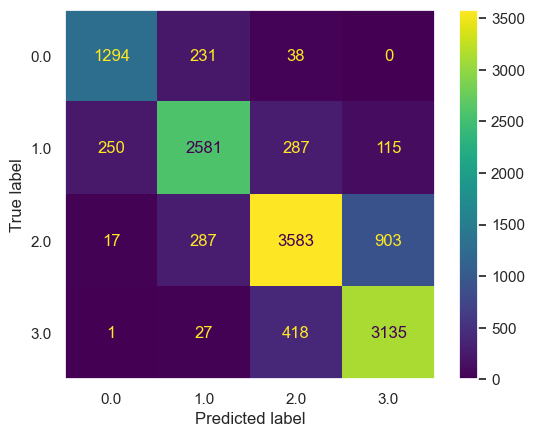

In [52]:
rf_ConfusionMatrix = metrics.confusion_matrix(Y_Train, predicted_rf_ada.to_numpy())
disp = metrics.ConfusionMatrixDisplay(rf_ConfusionMatrix, display_labels=rf_model_ada.classes_)
disp.plot(); plt.grid(visible=False); 

In [53]:
rf_ada_accuracy = metrics.accuracy_score(Y_Train, predicted_rf_ada)
rf_ada_roc_auc = metrics.roc_auc_score(Y_Train, probs_rf_ada.to_numpy(), multi_class='ovo')
rf_ada_confus_matrix = metrics.confusion_matrix(Y_Train, predicted_rf_ada)
rf_ada_classification_report = metrics.classification_report(Y_Train, predicted_rf_ada, zero_division=1)
rf_ada_precision = metrics.precision_score(Y_Train, predicted_rf_ada, pos_label=1, average='macro', zero_division=0)
rf_ada_recall = metrics.recall_score(Y_Train, predicted_rf_ada, pos_label=1, average='macro', zero_division=0)
rf_ada_f1 = metrics.f1_score(Y_Train, predicted_rf_ada, pos_label=1, average='macro', zero_division=0)

### Metricas en el set de Validacion.

In [54]:
predicted_rf1_ada = pd.DataFrame(rf_model_ada.predict(X_Test), columns=['Y_Predicted'])
probs_rf1_ada = pd.DataFrame(rf_model_ada.predict_proba(X_Test))

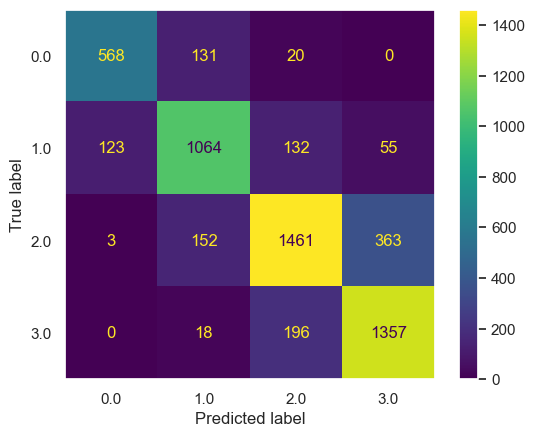

In [55]:
rf_ada_ConfusionMatrix1 = metrics.confusion_matrix(Y_Test, predicted_rf1_ada.to_numpy())
disp1 = metrics.ConfusionMatrixDisplay(rf_ada_ConfusionMatrix1, display_labels=rf_model_ada.classes_)
disp1.plot(); plt.grid(visible=False); plt.show()

In [56]:
rf_ada_accuracy1 = metrics.accuracy_score(Y_Test, predicted_rf1_ada)
rf_ada_roc_auc1 = metrics.roc_auc_score(Y_Test, probs_rf1_ada.to_numpy(), multi_class='ovo')
rf_ada_precision1 = metrics.precision_score(Y_Test, predicted_rf1_ada, pos_label=1, average='macro', zero_division=0)
rf_ada_recall1 = metrics.recall_score(Y_Test, predicted_rf1_ada, pos_label=1, average='macro', zero_division=0)
rf_ada_f11 = metrics.f1_score(Y_Test, predicted_rf1_ada, pos_label=1, average='macro', zero_division=0)

In [57]:
models_ada = pd.DataFrame({'Model':['Random Forest (AdaBoost) Train', 'Random Forest (AdaBoost) Test'],'Accuracy'
                       :[rf_ada_accuracy,rf_ada_accuracy1],'Precision':[rf_ada_precision,rf_ada_precision1],
                       'recall':[rf_ada_recall,rf_ada_recall1],'F1':[rf_ada_f1,rf_ada_f11],
                       'AUC ROC':[rf_ada_roc_auc,rf_ada_roc_auc1]})
models_ada.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,recall,F1,AUC ROC
0,Random Forest (AdaBoost) Train,0.804511,0.809301,0.812424,0.809180,0.904271
1,Random Forest (AdaBoost) Test,0.788588,0.792517,0.791600,0.790848,0.887957


## Selection of the best model.

After all the models have been trained and tested and the hyperparameters have been adjusted, the step that follows is to select the best model. To this end, metrics and computing times are summarised in the section below.

In [58]:
df_metricas = pd.concat([models,models_extra,models_pca,models_ada], axis=0, ignore_index=True)
df_metricas

,Model,Accuracy,Precision,recall,F1,AUC ROC
0,Random Forest Train,0.790081,0.802026,0.799809,0.795928,0.959200
1,Random Forest Test,0.777601,0.787547,0.783041,0.781082,0.950769
2,Random Forest (Extra) Train,0.765474,0.773805,0.773926,0.773085,0.944602
3,Random Forest (Extra) Test,0.763601,0.773395,0.769083,0.770844,0.940894
4,Random Forest (PCA) Train,0.963849,0.965503,0.971888,0.968154,0.997533
5,Random Forest (PCA) Test,0.958533,0.961147,0.967102,0.963594,0.996877
6,Random Forest (AdaBoost) Train,0.804511,0.809301,0.812424,0.809180,0.904271
7,Random Forest (AdaBoost) Test,0.788588,0.792517,0.791600,0.790848,0.887957


In [59]:
df_tiempo_entrenamiento = pd.DataFrame({'Random Forest':tiempo_entrenamiento_rf,
                                        'Random Forest (Extra)':tiempo_entrenamiento_rfExtra,
                                       'Random Forest (PCA)':tiempo_entrenamiento_rfPCA,
                                       'Random Forest (Ada)':tiempo_entrenamiento_rfABoost},index=[0])
df_tiempo_entrenamiento

,Random Forest,Random Forest (Extra),Random Forest (PCA),Random Forest (Ada)
0,10.556792,5.695793,0.966451,58.546369


# Prediction and output.

After the best model has been chosen, the next step is to feed it new data, the samples without labels. The trained model classifies the data, and a result analysis is conducted afterwards.

### Escalamiento de datos.

Con el objetivo de suavizar las curvas de los registros y mejorar la predicción, se tomo la decision de escalar los datos de la resolucion de 0.1524 metros, propia de los registros geofisicos de pozo a una resolucion de 1 metro. 
Este proceso se realizó tomando ventanas de 6 puntos y tomando la el valor de la mediana como representativo de toda la ventana.

In [60]:
Window_lengh = 7

In [61]:
df_temp = Upscale(df_CHTC,['ECGR','RHOZ','DTCO','NPHI'],Window_lengh,'none','DEPT')
df_upscaled = df_temp.join(df_CHTC['Well_ID'].filter(items=df_temp.index,axis=0))
df_upscaled.dropna(inplace=True)

Con el objetivo de analizar los resultados del proceso de escalamiento, se graficaron los registros originales y escalados.

In [62]:
#plt.subplots(figsize=(8,16))
#plt.plot(df_CHTC[df_CHTC['Well_ID'] == 'A15']['ECGR'],
#         df_CHTC[df_CHTC['Well_ID'] == 'A15']['DEPT'],label='ECGR',linestyle=':')
#plt.plot(df_upscaled[df_upscaled['Well_ID'] == 'A15']['ECGR'],
#         df_upscaled[df_upscaled['Well_ID'] == 'A15']['DEPT'],label='ECGR_Up',linestyle='-')
#plt.legend();plt.show()

**Lista de pozos predichos**

In [63]:
df_CHTC['Well_ID'].value_counts()

A11    5558
C5     5433
A12    5329
C41    5235
C56    5182
C15    5111
C51    4022
A14    3969
A13    3859
C59    3774
C42    3763
A8     3675
A15    3668
A17    3626
A3     3268
A7     2762
A4     2743
A6     2739
A5     1522
Name: Well_ID, dtype: int64

### Prediction using upscaled data.

In [64]:
df_pca_upscaled = Upscale(df_pca,['PC1','PC2','PC3'],Window_lengh,'none','DEPT')

In [65]:
start_time = time.time()
predicted_rf_extra_ChicoCanal = pd.DataFrame(rf_model_pca.predict(df_pca_upscaled[['PC1','PC2','PC3']]),
                                             columns=['RandomForest_Predicted'],index=df_pca_upscaled.index)
probs_rf_extra = pd.DataFrame(rf_model_pca.predict_proba(df_pca[['PC1','PC2','PC3']]))
finish_time = time.time(); tiempo_prediccion_rfExtra = finish_time - start_time
print('El tiempo que tarda en predecir es de ', tiempo_prediccion_rfExtra, 'segundos')

El tiempo que tarda en predecir es de  0.4907186031341553 segundos


In [66]:
df_upscaled_prediction = df_upscaled.join(predicted_rf_extra_ChicoCanal)
df_upscaled_prediction.to_csv(currdir + '\Resultados\Chicontepec_Canal_Etiquetado(Clases_Petrofisicas_1m).csv',
                              na_rep=-999.25, index=False)

In [67]:
df_upscaled_prediction

,DEPT,ECGR,RHOZ,DTCO,NPHI,Well_ID,RandomForest_Predicted
3,1126.5408,92.6591,2.4185,105.1499,0.3387,A3,3.0
10,1127.6076,88.4199,2.4436,100.7157,0.3333,A3,3.0
17,1128.6744,99.3233,2.4353,101.7196,0.3200,A3,3.0
24,1129.7412,90.7455,2.4601,99.4038,0.3126,A3,3.0
31,1130.8080,96.7902,2.4657,101.8623,0.3233,A3,3.0
...,...,...,...,...,...,...,...
75204,1727.6064,29.6648,2.6130,63.7407,0.0999,C59,0.0
75211,1728.6732,31.2674,2.5622,74.1557,0.1341,C59,1.0
75218,1729.7400,50.9753,2.5522,72.6794,0.1781,C59,1.0
75225,1730.8068,32.0399,2.5768,60.7589,0.1012,C59,0.0


### Prediction using original resolution data.

Para la creación del archivo de salida, se volvió a cargar el archivo original considerando que en este se encontraban datos importantes sobre los identificadores del pozo y demás. A este archivo se le adjunto la columna con las nuevas etiquetas para posteriormente producir un archivo de salida definitivo.

In [68]:
start_time = time.time()
predicted_rf_extra_ChicoCanal = pd.DataFrame(rf_model_pca.predict(df_pca[['PC1','PC2','PC3']]),
                                             columns=['Electrofacies_Class'],index=df_pca.index)
probs_rf_extra = pd.DataFrame(rf_model_pca.predict_proba(df_pca[['PC1','PC2','PC3']]))
finish_time = time.time(); tiempo_prediccion_rfExtra = finish_time - start_time
print('Prediction time', tiempo_prediccion_rfExtra, 'seconds')

El tiempo que tarda en predecir es de  0.9215669631958008 segundos


In [69]:
df_temp = pd.read_csv(currdir + '\\Datos\\Electrofacies_SOM.csv', low_memory=False, na_values=-999.25)
df_salida = pd.concat([df_CHTC,predicted_rf_extra_ChicoCanal], axis=1)
df_salida.to_csv(currdir + '\Resultados\Electrofacies_Predicted.csv', na_rep=-999.25, index=False)

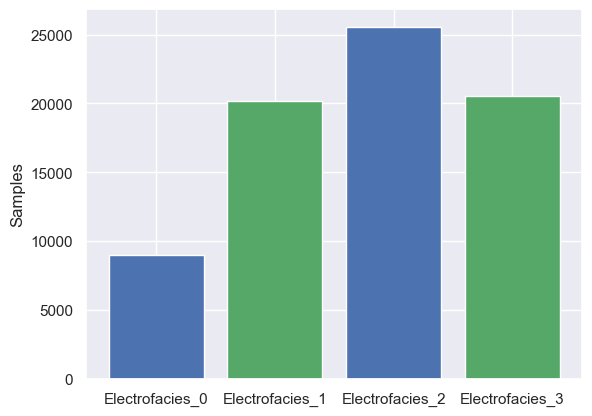

In [70]:
temp = df_salida['Electrofacies_Class'].value_counts().sort_index()
plt.bar(x=temp.index, height=temp.values, color=['b','g','b','g'],
        tick_label=['Electrofacies_0','Electrofacies_1','Electrofacies_2','Electrofacies_3'])
plt.ylabel("Samples")
plt.savefig(currdir + '\Resultados\\ClassCount.png', format="png", bbox_inches="tight", facecolor='white', dpi=300);